Notebook presenting basic implementation of Gillespie's first reaction method for simulating an SIR process on a network.

# Import libraries

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from numpy.random import Generator, PCG64, SeedSequence

In [2]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x7fce46765f60>


# SIR on network

## Define functions

In [3]:
##################################################################################################

def calculate_node_propensities(G, beta, mu):
    
    N = len(G)
    
    nx.set_node_attributes(G, 0., 'lambda')
    
    for i in range(N):
        #--- If node is susceptible calculate total propensity for infection: ---
        if G.nodes[i]['state'] == 0:
            # Get i's neighbors:
            neighbor_states = [G.nodes[j]['state'] for j in G.neighbors(i)] 

            # Total node rate from number of neighbors that are infectious:
            lambda_i = beta * np.sum([state==1 for state in neighbor_states])
            
            # Set node propensity and draw waiting time:
            if lambda_i > 0.:
                G.nodes[i]['lambda'] = lambda_i
                
                u_i = rg.random()
                G.nodes[i]['tau'] = -np.log(1. - u_i) / lambda_i
            
        #--- If node is infectious set propensity to mu: ---
        elif G.nodes[i]['state'] == 1:
            # Set node propensity:
            G.nodes[i]['lambda'] = mu    
            
            u_i = rg.random()
            G.nodes[i]['tau'] = -np.log(1. - u_i) / mu
    return()

##################################################################################################
##################################################################################################

def draw_next_event_first_reaction(G):
    '''Input: the network G.
    Output: selected reaction channel, i_selected, and the waiting time until the event, tau.'''
     
    # Get waiting times for active reaction channels from G:
    node_indices  = list(nx.get_node_attributes(G, 'tau'))
    waiting_times = list(nx.get_node_attributes(G, 'tau').values()) 
        
    # Select reaction with minimal waiting time:
    tau = np.min(waiting_times)
    
    i_selected = np.where(waiting_times == tau)[0][0]

    return(i_selected, tau)

##################################################################################################
##################################################################################################

def update_states(G, X, tau, i_selected):
    # State counts:
    S, I, R = X
    
    # Get node indices for active reaction channels from G:
    node_indices = list(nx.get_node_attributes(G, 'tau'))

    # Get node id corresponding to reaction channel i_0
    i_node = node_indices[i_selected] 

    #--- Update waiting times for remaining nodes: ---
    node_indices.pop(i_selected)
    
    for j in node_indices:
        G.nodes[j]['tau'] -= tau

    #===== Update network state: =====
    state_before = G.nodes[i_node]['state']

    #--- If state_before was S, update to I: ---
    if state_before==0:             
        # Update state counts: 
        S -= 1
        I += 1

        # Update state of node i_selected (S -> I): 
        G.nodes[i_node]['state'] = 1

        # Update node i_selected's propensity:
        G.nodes[i_node]['lambda'] = mu
        
        # Draw new waiting time for i_selected:
        u_i = rg.random()
        G.nodes[i_node]['tau'] = -np.log(1. - u_i) / mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i_node) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors: 
                # Update j's propensity:
                G.nodes[j]['lambda'] += beta
                   
                # Draw new waiting time for j:
                u_j = rg.random()
                G.nodes[j]['tau'] = -np.log(1. - u_j) / G.nodes[j]['lambda']

    #--- Else, if state_before was I, update to R: ---
    else: # (Note that this is a simple else statement since state_before is either S or I)
        # Update state counts: 
        I -= 1
        R += 1

        # Update state of node in graph: 
        G.nodes[i_node]['state'] = 2

        # Remove i from reaction channels:
        G.nodes[i_node]['lambda'] = 0.
        del G.nodes[i_node]['tau']

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i_node) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:            
                # Update j's propensity:
                G.nodes[j]['lambda'] -= beta
                                   
                # If node propensity is zero remove channel:
                if np.isclose(G.nodes[j]['lambda'], 0.):
                    del G.nodes[j]['tau']
                
                # Else, draw new waiting time for j:
                else:
                    u_j = rg.random()
                    G.nodes[j]['tau'] = -np.log(1. - u_j) / G.nodes[j]['lambda']

    return([S, I, R])

##################################################################################################
##################################################################################################

def first_reaction_method_SIR_graph_linear(G, beta, mu, T):
    
    #--- Initialization: ---
    node_states = nx.get_node_attributes(G, 'state')
    
    N = len(node_states)
    S = sum(X==0 for X in node_states.values())
    I = sum(X==1 for X in node_states.values())
    R = N - S - I 
    
    # Calculate and store node propensities:
    calculate_node_propensities(G, beta, mu)    

    # Set initial time t = 0:
    t = 0

    # Vector to save temporal evolution of state numbers over time: 
    X_t = [] 
    X_t.append([t, S, I, R])
    
    #--- Keep drawing events until t >= T: ---
    while t < T:
        # Check if no putative waiting times are left (no more reactions can happen):
        if len(nx.get_node_attributes(G,'tau')) == 0:
            X_t.append([T, S, I, R])
            break
        
        #===== First reaction event sampling step: =====
        i, tau = draw_next_event_first_reaction(G) 
       
        
        # Add waiting time to wall time:
        t += tau

        #===== Update: =====
        [S, I, R] = update_states(G, [S, I, R], tau, i)
        
        #--- Save current state numbers to X_t: ---
        X_t.append([t, S, I, R])
    
    return(np.array(X_t).transpose()) 

##################################################################################################

## $k$-regular graph 

## Simulate and plot

### Small number of individual realizations

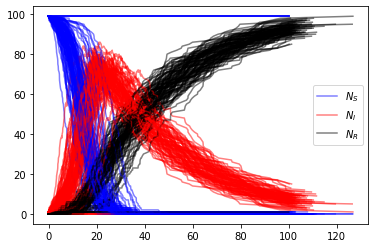

In [4]:
rg = Generator(PCG64(4))  # Initialize bit generator (here PCG64) with seed

#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Degree of nodes
N      = 100   # Number of nodes
T      = 100

number_of_simulations = 100

G0 = nx.random_regular_graph(d=k, n=N)

X_array = []

for q in range(number_of_simulations):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]

ax.legend(legends)

## Test speed

In [5]:
nx.set_node_attributes(G0, 'state', 0)
for i,state in enumerate(states):
    G0.nodes[i]['state'] = state       
    
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed

In [6]:
%%timeit

G1 = G0.copy()
first_reaction_method_SIR_graph_linear(G1, beta, mu, T)

37.3 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## ER graph 

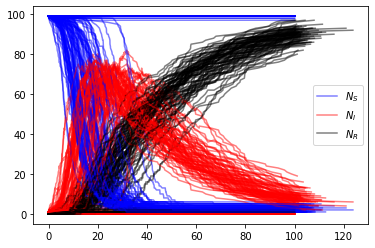

In [7]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

Q = 100

G0 = nx.gnm_random_graph(n=N, m=k*N/2)

X_array = []

for q in range(Q):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)
    
#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]
    
ax.legend(legends)

##  BA graph

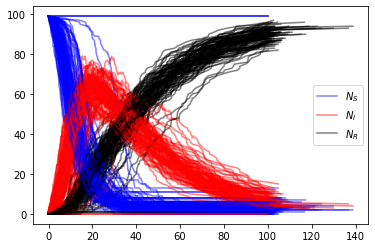

In [8]:
#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 4     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

Q = 100

G0 = nx.barabasi_albert_graph(n=N, m=int(k/2))

X_array = []

for q in range(Q):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]

ax.legend(legends)